# Basic Model Testing

In [1]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import sys

# Loading the Dataset

In [2]:
import os
import sys
sys.path.append(sys.path[0]+'/../lib') # Add library folder
#print(sys.path)

In [3]:
from opts import opts
from datasets.dataset_factory import get_dataset
from datasets.dataset.coco import COCO
from datasets.sample.ctdet import CTDetDataset
from trains.ctdet import CtdetTrainer
from trains.train_factory import train_factory

In [4]:
Dataset = get_dataset('coco', 'ctdet')

# Initializing opt

In [5]:
sys.path.append(sys.path[0]+'/../project_tools')
from fcn_opts import fcn_opts
opt = fcn_opts(Dataset)

Create opt for passing to the constructor. \
Also pass a string with the training value

# Loading Full Dataset

In [6]:
dataset = Dataset(opt,'train')
valset = Dataset(opt, 'val')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=14.26s)
creating index...
index created!
Loaded train 118287 samples
==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Loaded val 5000 samples


## Modifying dataset

For initial testing we are modifying the dataset to a smaller size. The following code updates the json file list to use a smalller subset of the data. 

In [7]:
all_Ids=dataset.coco.getImgIds()
all_Ids2=valset.coco.getImgIds()
print(len(all_Ids),len(all_Ids2))
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/train2017/'

118287 5000


In [8]:
M=128
import random
np.random.seed(0)
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids2))
    tmp=imgIds_perm[0:M].astype(int)
    tmp2=[all_Ids2[t] for t in tmp]
    valset.images=tmp2
    valset.num_samples=len(valset.images)
np.random.seed(2)

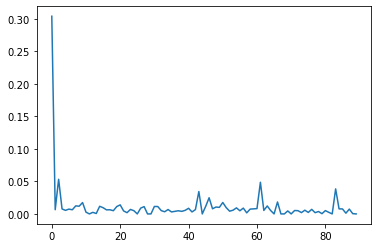

In [9]:
N=1024
import random
np.random.seed(0)
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids))
    tmp=imgIds_perm[0:N].astype(int)
    tmp2=[all_Ids[t] for t in tmp]
    dataset.images=tmp2
    dataset.num_samples=len(dataset.images)
    sub_inst_cat=np.zeros(90)
    for j in range(N):
        sub_cat_lab=[]
        img = dataset.coco.loadImgs(dataset.images[j])[0]
        f_name=img_dir
        f_name+=img['file_name']
        annIds = dataset.coco.getAnnIds(imgIds=img['id'])
        anns = dataset.coco.loadAnns(annIds)
        sub_cat_lab=[k['category_id'] for k in anns]
        for jj in range(90):
            t=np.where(np.asarray(sub_cat_lab)==jj)
            sub_inst_cat[jj-1]+=t[0].shape[0]
    prob_sub=(sub_inst_cat+1)/np.sum(sub_inst_cat+1)    
    plt.plot(sub_inst_cat/(np.sum(sub_inst_cat)))
np.random.seed(2)

In [10]:
np.random.seed(0)
np.random.permutation(5)

array([2, 0, 1, 3, 4])

In [11]:
opt.num_iters = dataset.num_samples/opt.batch_size
#print(dataset.images)

# Model

In [12]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [13]:
# regression on center point.
model = create_model(opt.arch, opt.heads, opt.head_conv)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution


In [14]:
optimizer = torch.optim.Adam(model.parameters(), opt.lr)

# Centernet_model Class

In [15]:
sys.path.append(sys.path[0]+"/../project_tools")
import nntools as nt

In [16]:
class Centernet_model(nt.NeuralNetwork,CtdetTrainer):
    def __init__(self,opt,model,optimizer=None,FineTune=True):
        nt.NeuralNetwork.__init__(self)
        CtdetTrainer.__init__(self,opt,model,optimizer=None)
        if FineTune:
            for name,param in model.named_parameters():
               if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
                    param = torch.randn(param.size()) # Random initialization
               else: 
                    param.requires_grad=False
            #print(name,param.requires_grad)
        self.model=model
        self.opt=opt
    def forward(self,x):
        return self.model(x)
    def criterion(self, y, d):
        return self.loss(y,d)

# Trainer

In [ ]:
trainer = CtdetTrainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

In [17]:
model =load_model(model,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');
net = Centernet_model(opt,model);
net = net.to(opt.device)
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  );

loaded /datasets/home/home-01/30/230/psarangi/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140


## Verification

In [ ]:
#for name,param in net.model.named_parameters():
#    print(name,param.size(),param.requires_grad)

## Learning Rate Variation

In [18]:
opt.lr=1.25e-4
net = Centernet_model(opt,model);
net = net.to(opt.device)
adam = torch.optim.Adam(net.parameters(), lr=opt.lr)
stats_manager = nt.StatsManager()
exp_lr_1 = nt.Experiment(net,dataset,valset,adam,stats_manager,
output_dir="Base_case_lr", batch_size=opt.batch_size,perform_validation_during_training=False)

In [19]:
exp_lr_1.run2(num_epochs=50)

Start/Continue training from epoch 50
Finish training for 50 epochs


## Set Learning rate=1.25e-3

In [24]:
opt.lr=1.25e-3

In [25]:
net2 = Centernet_model(opt,model);
net2 = net2.to(opt.device)
adam2 = torch.optim.Adam(net2.parameters(), lr=opt.lr)
stats_manager2 = nt.StatsManager()
exp_lr_2 = nt.Experiment(net2,dataset,valset,adam2,stats_manager2,
output_dir="Experiment_lr_2", batch_size=opt.batch_size,perform_validation_during_training=False)

In [ ]:
exp_lr_2.run2(num_epochs=50)

Start/Continue training from epoch 7
Epoch 8 (Time: 220.98s)
Epoch 9 (Time: 224.15s)
Epoch 10 (Time: 233.99s)
Epoch 11 (Time: 218.33s)
Epoch 12 (Time: 222.28s)


## Set Learning Rate 1.25e-5

In [ ]:
opt.lr=7.25e-4

In [ ]:
net3 = Centernet_model(opt,model);
net3 = net3.to(opt.device)
adam3 = torch.optim.Adam(net3.parameters(), lr=opt.lr)
stats_manager3 = nt.StatsManager()
exp_lr_3 = nt.Experiment(net3,dataset,valset,adam3,stats_manager3,
output_dir="Experiment_lr_3", batch_size=opt.batch_size,perform_validation_during_training=False)

In [ ]:
exp_lr_3.run2(num_epochs=20)

In [ ]:
opt.lr=1e3
net4 = Centernet_model(opt,model);
net4 = net4.to(opt.device)
adam4 = torch.optim.Adam(net3.parameters(), lr=opt.lr)
stats_manager4 = nt.StatsManager()
exp_lr_4 = nt.Experiment(net4,dataset,valset,adam4,stats_manager4,
output_dir="Experiment_lr_4", batch_size=opt.batch_size,perform_validation_during_training=False)

In [ ]:
exp_lr_4.run2(num_epochs=10)

In [ ]:
opt.lr=1.25e-2
net5 = Centernet_model(opt,model);
net5 = net5.to(opt.device)
sgd1 = torch.optim.SGD(net5.parameters(), lr=opt.lr)
stats_manager5 = nt.StatsManager()
exp_lr_5 = nt.Experiment(net5,dataset,valset,sgd1,stats_manager5,
output_dir="ExperimentSGD_lr_1", batch_size=opt.batch_size,perform_validation_during_training=False)

In [ ]:
exp_lr_5.run2(num_epochs=10)

In [ ]:
opt.lr=1.25e-4
net6 = Centernet_model(opt,model);
net6 = net6.to(opt.device)
sgd2 = torch.optim.SGD(net5.parameters(), lr=opt.lr)
stats_manager6 = nt.StatsManager()
exp_lr_6 = nt.Experiment(net6,dataset,valset,sgd2,stats_manager6,
output_dir="ExperimentSGD_lr_2", batch_size=opt.batch_size,perform_validation_during_training=False)

In [ ]:
exp_lr_6.run2(num_epochs=10)

NameError: name 'exp_lr_3' is not defined

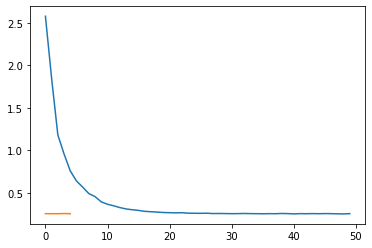

In [22]:
plt.figure(1)
plt.plot(exp_lr_1.history)
plt.plot(exp_lr_2.history)
plt.plot(exp_lr_3.history)
#plt.plot(exp_lr_5.history)
#plt.plot(exp_lr_6.history)
plt.show()

In [20]:
val_loader_2 = td.DataLoader(
      valset, 
      batch_size=1, 
      shuffle=False,
      num_workers=1,
      pin_memory=True,
      drop_last=True
  );
print(valset.num_samples)

128


In [21]:
exp_lr_1.val_loader=val_loader_2

In [22]:
exp_lr_1.evaluate2()

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0.2580803583841771

In [26]:
exp_lr_2.val_loader=val_loader_2
exp_lr_2.evaluate2()

0.26157366787083447